In [1]:
import os
import tarfile

import os, json, pprint, re, pickle, time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import & Load Data

In [2]:
# Path to the .tar.gz file
local_tar_gz = '/content/drive/MyDrive/AI/Indonesia_ai/project/project_2/dataset/liputan6_data.tar.gz'

# Open the tar.gz file
with tarfile.open(local_tar_gz, 'r:gz') as tar:
    # Extract all contents to the specified directory
    tar.extractall('/tmp')

print("Extraction complete.")

Extraction complete.


In [3]:
data_path = "/tmp"

folder_data = "liputan6_data"
dataset_type = "canonical"

In [4]:
train_dir = os.path.join(data_path, folder_data, dataset_type, "train")
val_dir = os.path.join(data_path, folder_data, dataset_type, "dev")
test_dir = os.path.join(data_path, folder_data, dataset_type, "test")

In [5]:
def unwrap_text(texts):
    text_string = ""
    for text in texts:
        text_string += " ".join(text)
        text_string += " "
    return re.sub(r'^.*?:', '', text_string).strip()

def get_data(dir, n_data=None):
    """ Collect all articles and summaries.

        Parameters
        ----------
        n_data: number of desired articles to be collected
     """
    data = []
    filenames = os.listdir(dir)
    for i in range(len(filenames)):
        try:
            json_data = json.load(open(os.path.join(dir, filenames[i])))
            article = unwrap_text(json_data['clean_article'])
            summary = unwrap_text(json_data['clean_summary'])
            data.append(dict(article=article, summary=summary))
        except Exception as e:
            print(f"Exception during processing {filenames[i]}: {e}")
            continue
        if n_data and len(data) == n_data: break
    return data

In [6]:
unwrap_text(json.load(open(os.path.join(train_dir, "299993.json")))['clean_article'])

'Pengusaha ternama Donald Trump dikabarkan sedang mempertimbangkan untuk beralih ke dunia politik dengan mencalonkan diri sebagai presiden Amerika Serikat pada tahun 2012 , barubaru ini . Miliarder ini mengaku untuk perubahan karirnya dan memiliki keinginan untuk mengambil alih Gedung Putih dari kepemimpinan Barack Obama , karena dia mengkhawatirkan tentang keadaan industri manufaktur negara . Trump mengatakan kepada Fox News , " Saya sudah begitu banyak memiliki orang selama bertahun-tahun yang meminta saya untuk terjun ke dunia politik . Dan untuk pertama kalinya dalam hidup saya , saya benar-benar berpikir untuk melakukan hal itu , " ujar Trump . Namun , Trump juga mengaku khawatir ambisi politiknya mungkin tidak akan pernah membuahkan hasil . Ia menambahkan , " Saya belum tahu akan melakukannya . Dan ada kemungkinan juga saya tidak akan melakukannya , saya masih memikirkannya . " Gak yakin ya Trump . ( contactmusic/AYB ) .'

In [7]:
# cross check clean summary
unwrap_text(json.load(open(os.path.join(train_dir, "299993.json")))['clean_summary'])

'Donald Trump dikabarkan sedang mempertimbangkan untuk beralih ke dunia politik dengan mencalonkan diri sebagai presiden Amerika Serikat pada tahun 2012 .'

In [9]:
# collect data
train_data = get_data(train_dir,1000)
val_data = get_data(val_dir,1000)
test_data = get_data(test_dir,1000)

In [10]:
print(len(train_data), len(val_data), len(test_data))

1000 1000 1000


## EDA


### Length

In [25]:
train_data

[{'article': 'Para guru yang gemar merokok kini perlu berhati-hati . Pasalnya , guru yang kedapatan merokok saat mengajar bisa diberi sanksi , bahkan dipecat . Kebijakan tersebut tengah disosialisasikan di berbagai sekolah di Kepulauan Sula , Maluku Utara . Keputusan Bupati Kepulauan Sula , Ahmad Hidayat Mus , untuk mengeluarkan peraturan tentang larangan merokok bagi guru saat mengajar disambut baik mayoritas siswa . Selain dinilai tak sehat , kebiasaan merokok saat mengajar bisa mengganggu suasana belajar dan memberi contoh kurang baik kepada para siswa . Agar kebijakan ini bisa berjalan , bupati meminta kepala sekolah dan siswa ikut mengawasi para guru . Bagi guru yang kedapatan merokok di kelas bakal diberi sanksi . Jika masih membandel , bisa dipecat . ( YNI/Sawaludin ) .',
  'summary': 'Peraturan tentang larangan guru merokok dalam kelas mulai diterapkan di berbagai sekolah di Kepulauan Sula , Maluku Utara . Jika kedapatan merokok dalam kelas , akan dikenai sanksi , bahkan dipeca

In [11]:
def plot_length(dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    plt.suptitle(plot_name)

    for i, content in enumerate(['article', 'summary']):
        len_data = [len(x[content]) for x in dataset]
        sns.histplot(len_data, ax=axs[i])
        axs[i].set_title(f"{content} Length")
        axs[i].set_xlabel(f"{content}")
        print(f"Average length of {content}: {np.mean(len_data)}")
    plt.show()

Average length of article: 1375.316
Average length of summary: 198.293


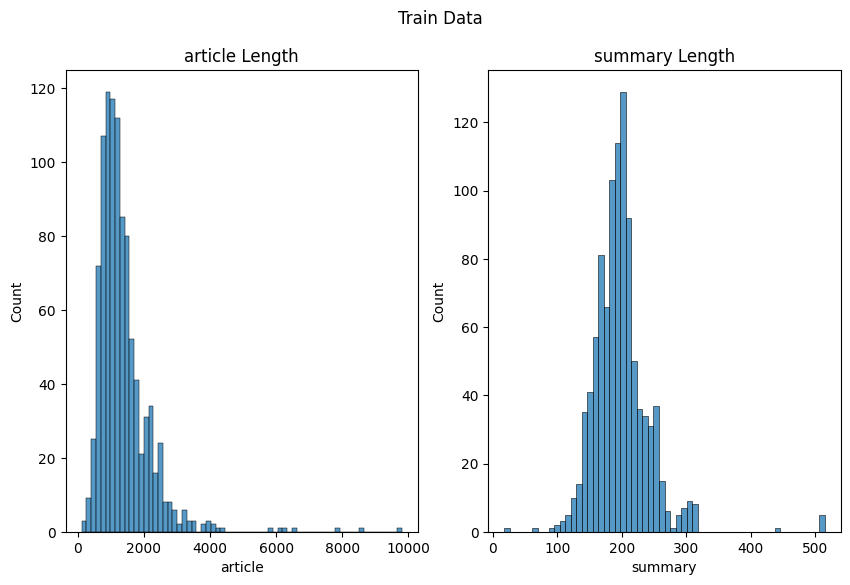

In [12]:
plot_length(train_data, "Train Data")

Average length of article: 1449.563
Average length of summary: 162.038


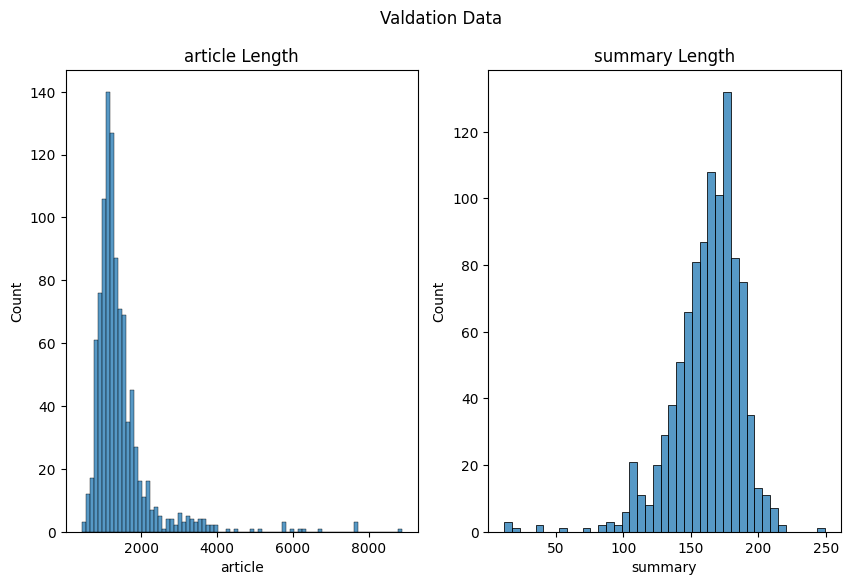

In [13]:
plot_length(val_data, "Valdation Data")

Average length of article: 1402.949
Average length of summary: 174.014


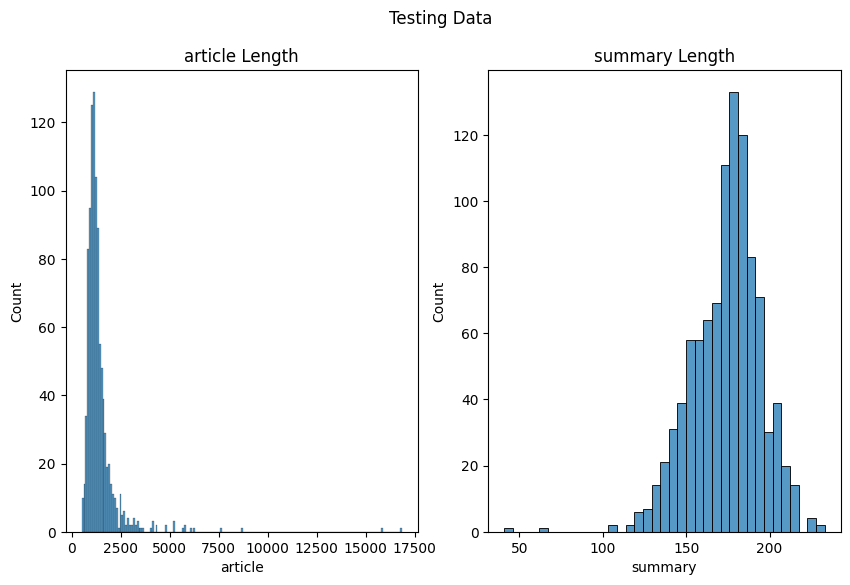

In [14]:
plot_length(test_data, "Testing Data")

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
def plot_top_ngram(n_gram, dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    plot_name += f"-- top 10 {n_gram}-gram words"
    plt.suptitle(plot_name)


    for i, content in enumerate(['article', 'summary']):
        all_data = [x[content] for x in dataset]

        vec = CountVectorizer(ngram_range=(n_gram, n_gram)).fit(all_data)
        bag_of_words = vec.transform(all_data)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        word, count_word = map(list, zip(*freq[:10]))  # top 10 words

        sns.barplot(x=count_word, y=word, ax=axs[i])
        axs[i].set_title(f"{content} Length")
        axs[i].set_xlabel(f"count")
        axs[i].set_ylabel("n_gram_words")
    plt.tight_layout()
    plt.show()

### Most Frequent Words (UniGram, BiGram)

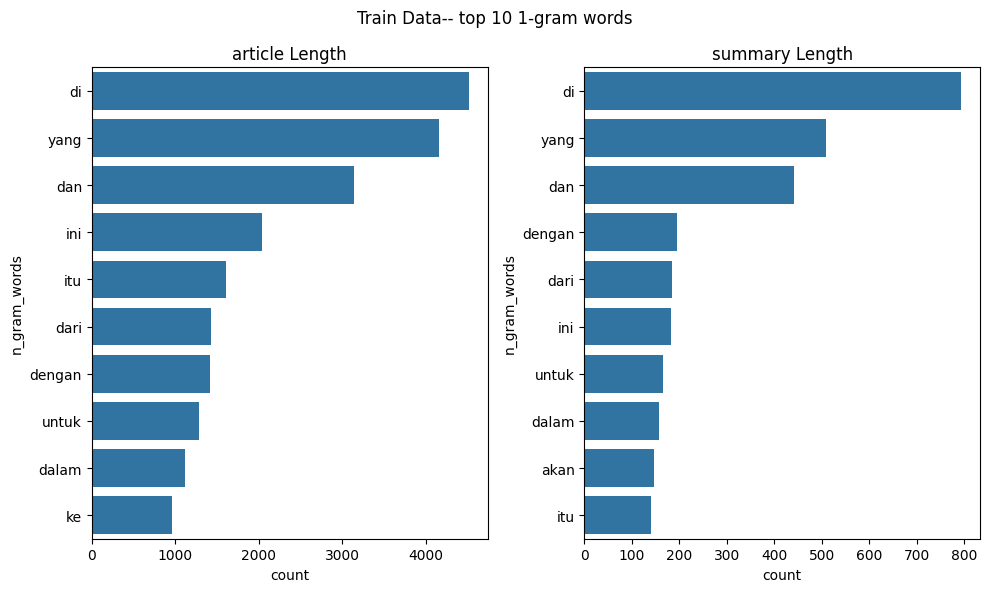

In [17]:
# unigram train set
plot_top_ngram(1, train_data, "Train Data")

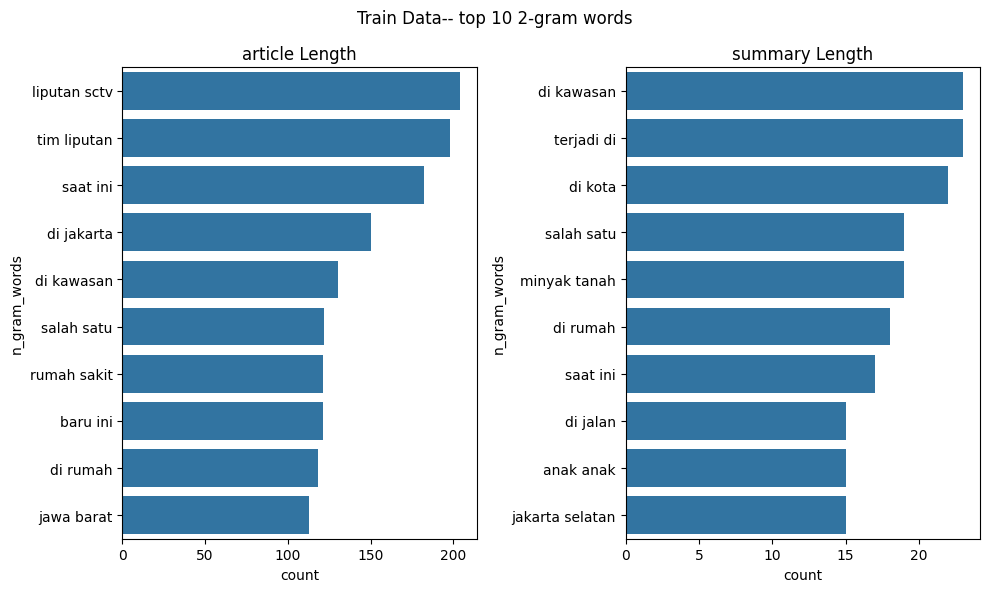

In [18]:
# bigram train set
plot_top_ngram(2, train_data, "Train Data")

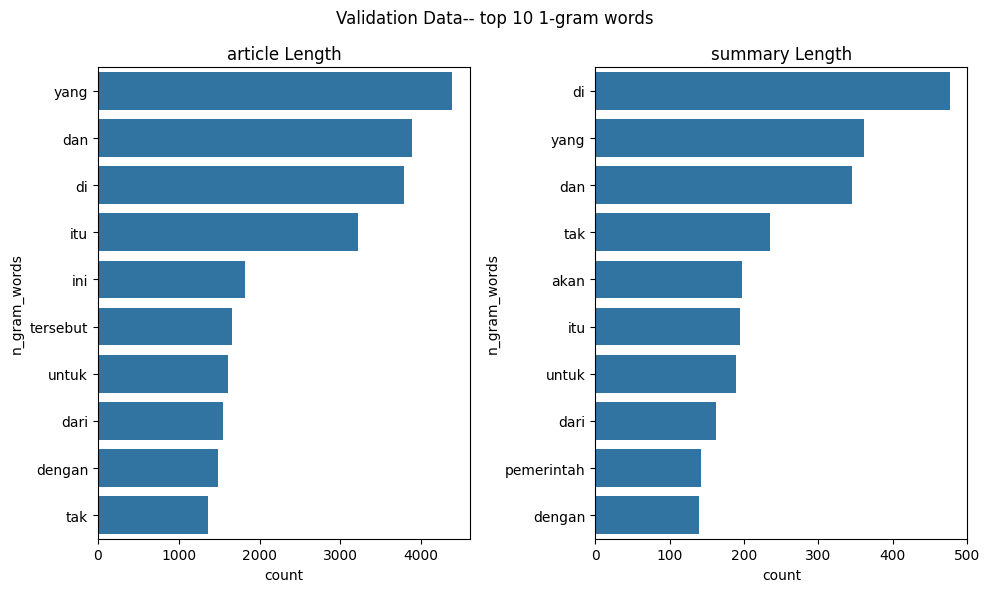

In [19]:
# unigram validation set
plot_top_ngram(1, val_data, "Validation Data")

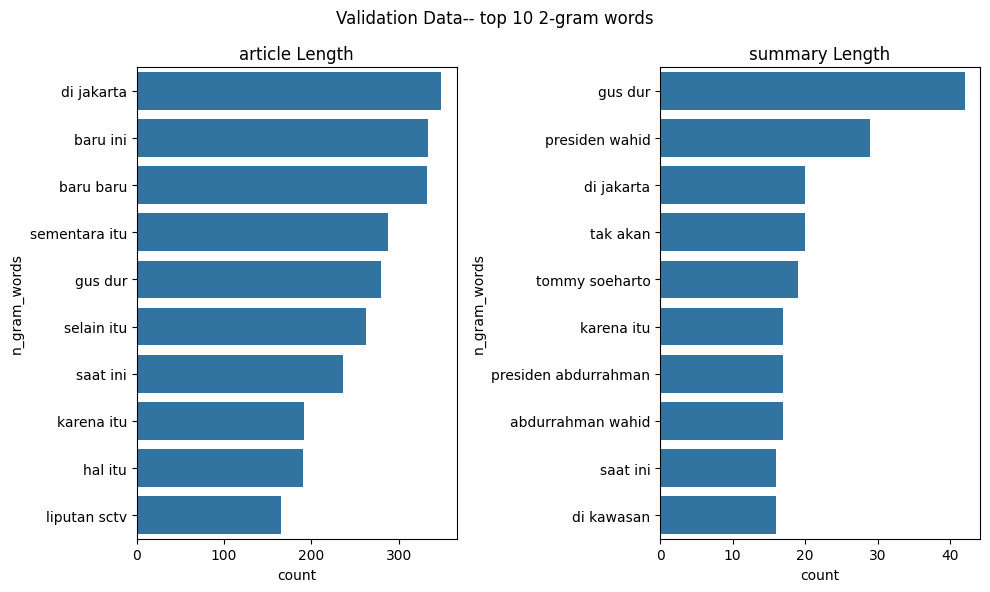

In [20]:
# bigram validation set
plot_top_ngram(2, val_data, "Validation Data")

### Wordcloud

In [21]:
from wordcloud import WordCloud

In [22]:
wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      max_font_size=30,
                      scale=3,
                      random_state=42)

def plot_wordcloud(dataset, plot_name):
    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    # plt.suptitle(f"WordCloud for {plot_name}")
    for i, content in enumerate(['article', 'summary']):
        corpus = []
        for data in dataset:
            corpus.extend(data[content].split())

        wc = wordcloud.generate(str(corpus))
        axs[i].imshow(wc)
        axs[i].axis('off')
        axs[i].set_title(f"{content}")

    plt.show()

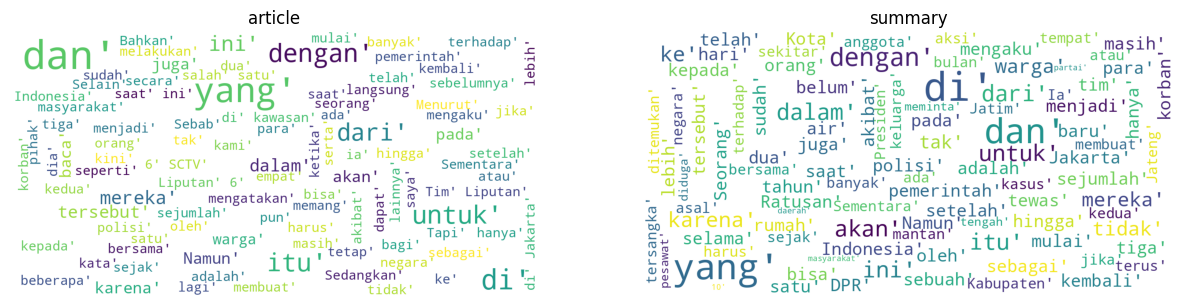

In [23]:
# wordcloud train set
plot_wordcloud(train_data, "Train Data")

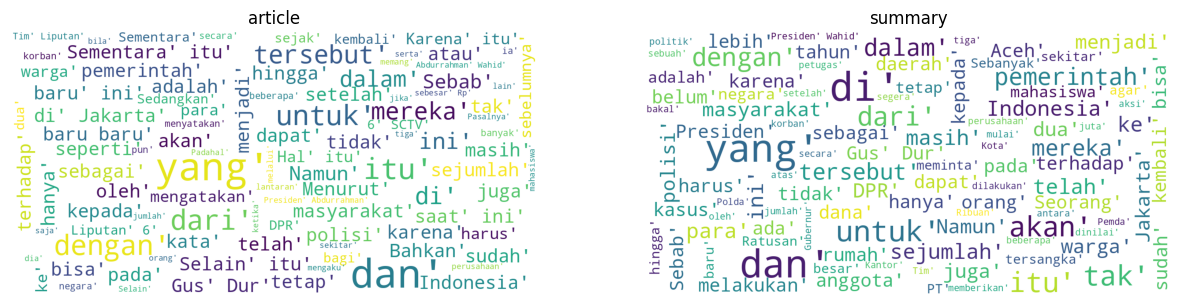

In [24]:
# wordcloud validation set
plot_wordcloud(val_data, "Validation Data")